# Dynamical Modeling of Paleomagnetic Poles

In [2]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 20)

from utils import cartesian2spherical, spherical2cartesian

### 1. Read and Exploration of the data

In [4]:
max_age = 130   # Maximum ages in the past to explore

In [7]:
df = pd.read_csv('Torsvik-etal-2012_dataset.csv', encoding="cp1254")
df = df[df.Age < max_age]

# For PPs in African coordinate system, we just replace the actual latitude and longitude 
df.RLat.fillna(df.Lat, inplace=True)
df.RLon.fillna(df.Lon, inplace=True)

# Add cartesian coordinates
df['x'] = df.apply(lambda row: spherical2cartesian([np.radians(row["RLat"]), np.radians(row.RLon)])[0], axis=1) 
df['y'] = df.apply(lambda row: spherical2cartesian([np.radians(row["RLat"]), np.radians(row.RLon)])[1], axis=1) 
df['z'] = df.apply(lambda row: spherical2cartesian([np.radians(row["RLat"]), np.radians(row.RLon)])[2], axis=1) 

df.head()

,Q,a95,Plate,Plate_code,Lat,Lon,CLat,CLon,RLat,RLon,Eplat,Eplong,Epang,Age,x,y,z
0,5,4.8,north_america,101,-86.3,5.7,NaN,NaN,-86.3,5.7,NaN,NaN,NaN,0.5,0.064213,0.006409,-0.997916
1,5,9.1,north_america,101,-86.4,8.4,NaN,NaN,-86.4,9.2,79.2,23.0,0.2,0.8,0.061983,0.010039,-0.998027
2,5,7.1,north_america,101,-85.3,265.9,NaN,NaN,-85.3,-94.1,79.9,22.7,0.3,1.0,-0.005858,-0.081729,-0.996637
3,5,8.7,north_america,101,-88.4,225.5,NaN,NaN,-88.4,-135.7,79.9,22.7,0.3,1.0,-0.019983,-0.019501,-0.999610
4,5,4.3,north_america,101,-88.9,285.0,NaN,NaN,-88.9,-75.1,79.9,22.7,0.3,1.0,0.004936,-0.018552,-0.999816


We can see which are the sites on the globe where more studies where perform:

In [5]:
df.Plate.value_counts()

north_america       66
europe              29
East_Gondwana       16
Northeast_Africa    16
greenland           11
Somalia             10
Amazonia            10
Madagascar           9
Northwest_Africa     5
East_Antarctica      4
Patagonia            4
Parana               4
Arabia               3
Australia            3
Southern_Africa      2
Colorado             1
Meseta               1
Name: Plate, dtype: int64

We can plot the set of all paleomagnetic poles. We can see that the dispersion is quite large, and it is not simple to see an obvious patter. However, we can see how the poles get apart of the south pole as we go backwards in time. 

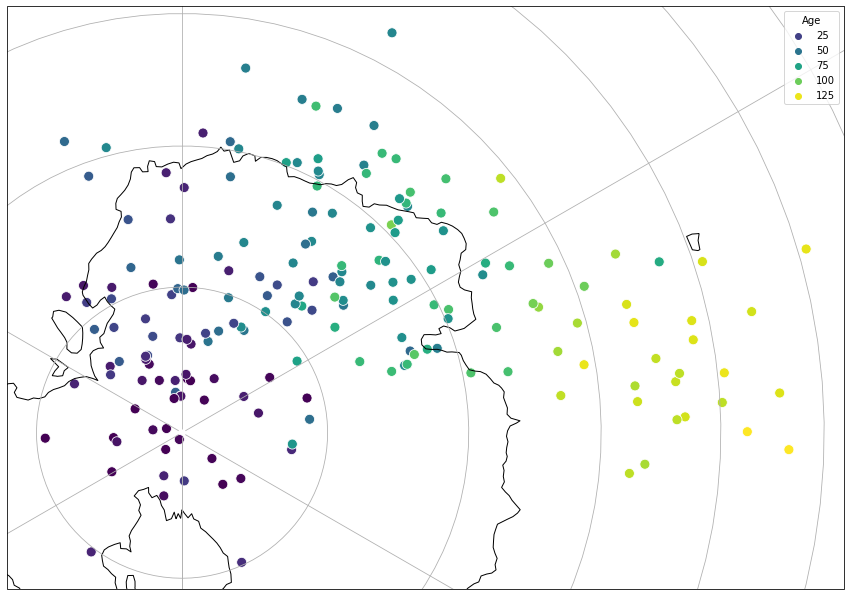

In [15]:
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-90))

ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['RLon'], y = df['RLat'], 
                hue = df['Age'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

#plt.savefig("PPs.pdf", format="pdf", bbox_inches="tight")

Now, we can define a running mean that averages the PPs around their Fisherian mean on the sphere

In [10]:
def running_mean_APWP(data,window_length,spacing,max_age,min_age,fig_name=None):
    """
    Code from Nick Swanson-Hysell
    """
    mean_pole_ages = np.arange(min_age,max_age+spacing,spacing)
    running_means = pd.DataFrame(columns=['Age','N','a95','RLon','RLat'])
    for age in mean_pole_ages:
        window_min = age - (window_length/2)
        window_max = age + (window_length/2)
        poles = data.loc[(data['Age'] >= window_min) & (data['Age'] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles['RLon'].tolist(),inc=poles['RLat'].tolist())
        running_means.loc[age] = [age,mean['n'],mean['alpha95'],mean['dec'],mean['inc']]
    return running_means

In [11]:
df_RM = running_mean_APWP(df, 15, 1, max_age, 0)
df_RM

,Age,N,a95,RLon,RLat
0,0.0,26.0,1.778784,345.764157,-88.457608
1,1.0,31.0,1.668985,348.317156,-87.891483
2,2.0,33.0,1.647778,345.425394,-87.525288
3,3.0,35.0,1.648784,340.213364,-87.177248
4,4.0,39.0,1.763445,349.723539,-86.514175
...,...,...,...,...,...
126,126.0,14.0,3.615167,81.299533,-50.622989
127,127.0,13.0,3.774920,80.983817,-50.122721
128,128.0,11.0,4.375717,80.661645,-50.204108
129,129.0,9.0,5.017506,82.300739,-49.543473


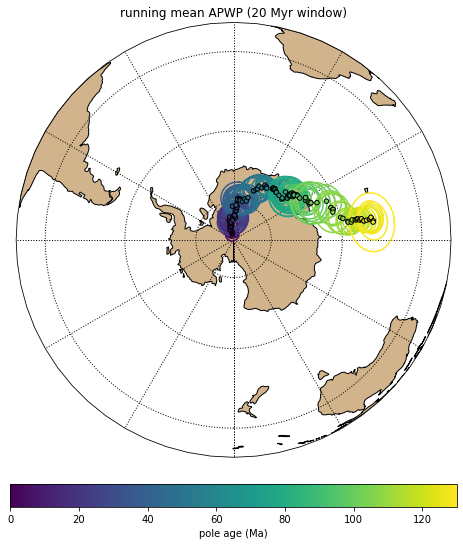

In [14]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, df_RM.RLon.tolist(), df_RM.RLat.tolist(), 
                 df_RM.a95.tolist(), df_RM.Age.tolist(),0,max_age)
plt.title('running mean APWP (20 Myr window)');

#plt.savefig("RM.pdf", format="pdf", bbox_inches="tight")

## 2. Trajectory Matching

For simplicity, let's consider first the case of a single trajectory. Furthermore, we are going to start with simulated data in order to illustrate our examples. From the present paleomagnetic pole located in the South hemisphere, we are going to construct more paleomagnetic poles following a solid rotation with fixed angular velocity. The angular velocity and the rotation axis are sample randomly. On top of the paleomagnetic poles, we add von Mises-Fisherian noise.

In [16]:
N = 40    # number of paleomagnetic poles

min_omega = np.radians(0.5)   # Minimum angular velocity
max_omega = np.radians(2.5)   # Maximum angular velocity

sigma = np.radians(5) # noise to pp 

# sample random uniform ages for each PP
ages = np.random.uniform(0, 40, N)
ages = sorted(ages)

# sample angular velocity
omega = np.random.uniform(min_omega, max_omega)

# initial paleomagnetic pole
pp0 = [0,0,-1]

# Euler pole (rotation axis)
ep = np.random.normal(0,1,3)
ep /= np.linalg.norm(ep)

PPs = []

for age in ages:
    
    # Define rotation aroung the Euler pole for each age
    Rot = rotation.from_rotvec( (omega * age) * ep )
    
    pp = Rot.apply(pp0)
    
    # add Fisherian noise
    pp += np.random.normal(0, sigma, 3)
    pp /= np.linalg.norm(pp)
    
    PPs.append(pp)

We just convert the simulated dataset into a nicer format

In [17]:
PPs_spherical = map(cartesian2spherical, PPs)

dictionatry = {"Age": ages, 
               "PP_x": [x[0] for x in PPs],
               "PP_y": [x[1] for x in PPs],
               "PP_z": [x[2] for x in PPs]}

df_fake = pd.DataFrame(dictionatry)

In [18]:
df_fake["RLat_rad"] = df_fake.apply(lambda x: cartesian2spherical([x["PP_x"], x["PP_y"], x["PP_z"]])[0], axis=1)
df_fake["RLon_rad"] = df_fake.apply(lambda x: cartesian2spherical([x["PP_x"], x["PP_y"], x["PP_z"]])[1], axis=1)

df_fake["RLat"] = np.degrees(df_fake.RLat_rad)
df_fake["RLon"] = np.degrees(df_fake.RLon_rad)

df_fake.head(5)

,Age,PP_x,PP_y,PP_z,RLat_rad,RLon_rad,RLat,RLon
0,1.011565,-0.029979,-0.082958,-0.996102,-1.482473,-1.917563,-84.939423,-109.868249
1,3.438985,0.212333,0.076572,-0.974193,-1.343117,0.346107,-76.954914,19.830498
2,3.980507,0.195668,0.099374,-0.975622,-1.349539,0.469924,-77.322907,26.924687
3,4.148668,0.061072,0.206070,-0.976630,-1.354177,1.282678,-77.588614,73.492010
4,4.740018,0.041661,-0.028291,-0.998731,-1.520416,-0.596554,-87.113436,-34.180025


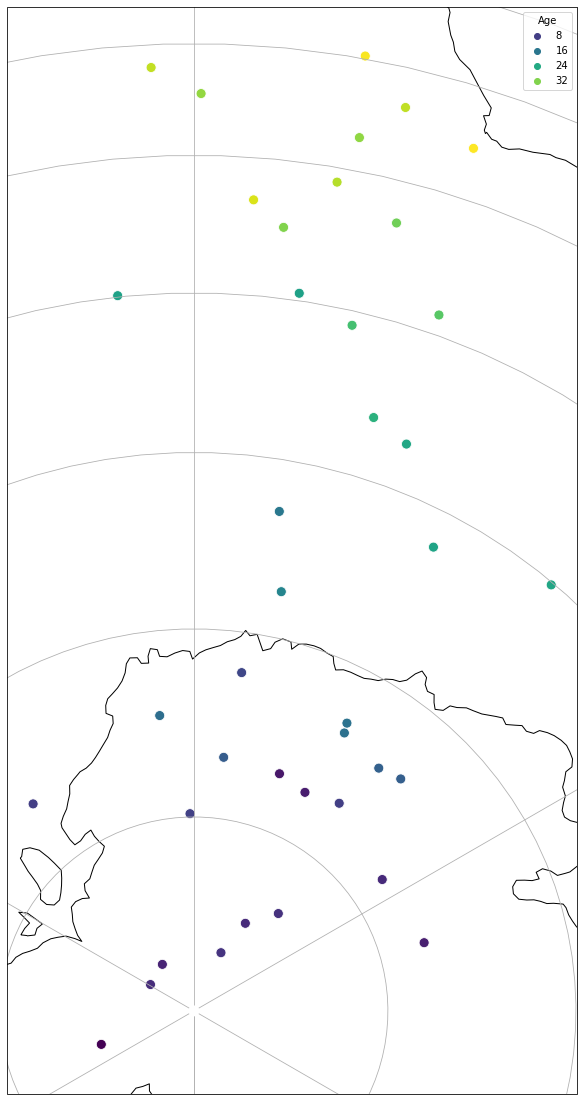

In [19]:
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-90))

ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df_fake['RLon'], y = df_fake['RLat'], 
                hue = df_fake['Age'],  s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

#plt.savefig("Segment_example.pdf", format="pdf", bbox_inches="tight")

We now define the loss function for trajectory matching. In order to this to work, we just need to define a function that takes as argument the parameter to be optimized and returns the total loss. Since most of the mathematical operations that we use here are easily differentiable, they are easy to optimize using the sklearn toolbox.'

In [55]:
def loss_TM (l):
    
    res = 0
    
    for i in range(N):
        
        pp = PPs[i]
        age = ages[i]
        
        R = rotation.from_rotvec(age * l)
        pp_hat = R.apply([0,0,-1])
        
        res += np.linalg.norm(pp - pp_hat) ** 2
        
    return res

For robustness, we run the optimization method starting at different random points. 

In [56]:
%%time

optimum = np.nan
optimum_fun = np.inf

for _ in range(10):
    
    initial_guess = np.random.normal(0,1,3)
    initial_guess /= np.linalg.norm(initial_guess)
    initial_guess *= np.random.uniform(min_omega, max_omega)

    
    opt = minimize(loss_TM, x0=initial_guess, method = "CG", options = {'gtol': 1E-5})

    if opt.fun < optimum_fun:
        optimum = opt
        optimum_fun = opt.fun
        
optimum

CPU times: user 3.22 s, sys: 23.5 ms, total: 3.25 s
Wall time: 3.24 s


     fun: 0.46588984751608636
     jac: array([ 6.357207894325256e-05,  3.140978515148163e-04,
       -2.161040902137756e-05])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 438
     nit: 29
    njev: 107
  status: 2
 success: False
       x: array([-0.003058570760843, -0.004659851773262,  0.062865671775983])

We can see for example that the value of the angular velocity are similar:

In [57]:
np.degrees(omega)

1.6468949453848156

In [58]:
np.degrees(np.linalg.norm(optimum.x))

3.616068130408331

### 2.2. Error quantification in simulated data

Now we are going to run the same analysis than in the previous section but in multiple realization of the segment. In order to do that, we encapsulate part of the code in the previous section into functions and we run for different intensities of noise and realizations of the segment.  

In [59]:
def generate_fake_segment(sigma): 
    
    # sample random uniform ages for each PP
    ages = np.random.uniform(0, 40, N)
    ages = sorted(ages)

    # sample angular velocity
    omega = np.random.uniform(min_omega, max_omega)

    # initial paleomagnetic pole
    pp0 = [0,0,-1]

    # Euler pole (rotation axis)
    ep = np.random.normal(0,1,3)
    ep /= np.linalg.norm(ep)

    PPs = []

    for age in ages:

        # Define rotation aroung the Euler pole for each age
        Rot = rotation.from_rotvec( (omega * age) * ep )

        pp = Rot.apply(pp0)

        # add Fisherian noise
        pp += np.random.normal(0, sigma, 3)
        pp /= np.linalg.norm(pp)

        PPs.append(pp)
        
    return ages, PPs, omega * ep

def fit_segment(ages_, PPs_):
    
    def loss_TM (l):
    
        res = 0

        for i in range(N):

            pp = PPs_[i]
            age = ages_[i]

            R = rotation.from_rotvec(age * l)
            pp_hat = R.apply([0,0,-1])

            res += np.linalg.norm(pp - pp_hat) ** 2

        return res
    
    optimum = np.nan
    optimum_fun = np.inf

    for _ in range(10):

        initial_guess = np.random.normal(0,1,3)
        initial_guess /= np.linalg.norm(initial_guess)
        initial_guess *= np.random.uniform(min_omega, max_omega)


        opt = minimize(loss_TM, x0=initial_guess, method = "Nelder-Mead", options = {'gtol': 1E-5})

        if opt.fun < optimum_fun:
            optimum = opt
            optimum_fun = opt.fun
            
    return optimum

And now we run the different simulations

In [60]:
%%time

Error_omega = []
Error_ep = []
all_sigma = []

for sg in np.radians(np.linspace(0.0, 20, 5)):
    
    for _ in range(100):
    
        ages, PPs, L = generate_fake_segment(sg)
        optimum = fit_segment(ages, PPs)
    
        all_sigma.append(np.degrees(sg).round(2))
        Error_omega.append(np.abs(np.linalg.norm(L)-np.linalg.norm(optimum.x)))
        
        angle = min( np.degrees(np.arccos( np.dot(L, optimum.x) / ( np.linalg.norm(optimum.x) * np.linalg.norm(L) ))), 
                     np.degrees(np.arccos( np.dot(-L, optimum.x) / ( np.linalg.norm(optimum.x) * np.linalg.norm(L) ))))
        
        Error_ep.append(angle)

CPU times: user 9min 11s, sys: 2.25 s, total: 9min 14s
Wall time: 9min 15s


In [62]:
df_TM_error = pd.DataFrame({"sigma": all_sigma, "Error_omega": Error_omega, "Error_ep": Error_ep})
df_TM_error.head()

,sigma,Error_omega,Error_ep
0,0.0,0.000006,0.037004
1,0.0,0.000002,0.012164
2,0.0,0.000006,0.065739
3,0.0,0.000003,0.030424
4,0.0,0.000009,0.009372


We can see how the error in both angular velocity and position of the Euler pole increase as a function of the noise. 

(0.0, 0.03490658503988659)

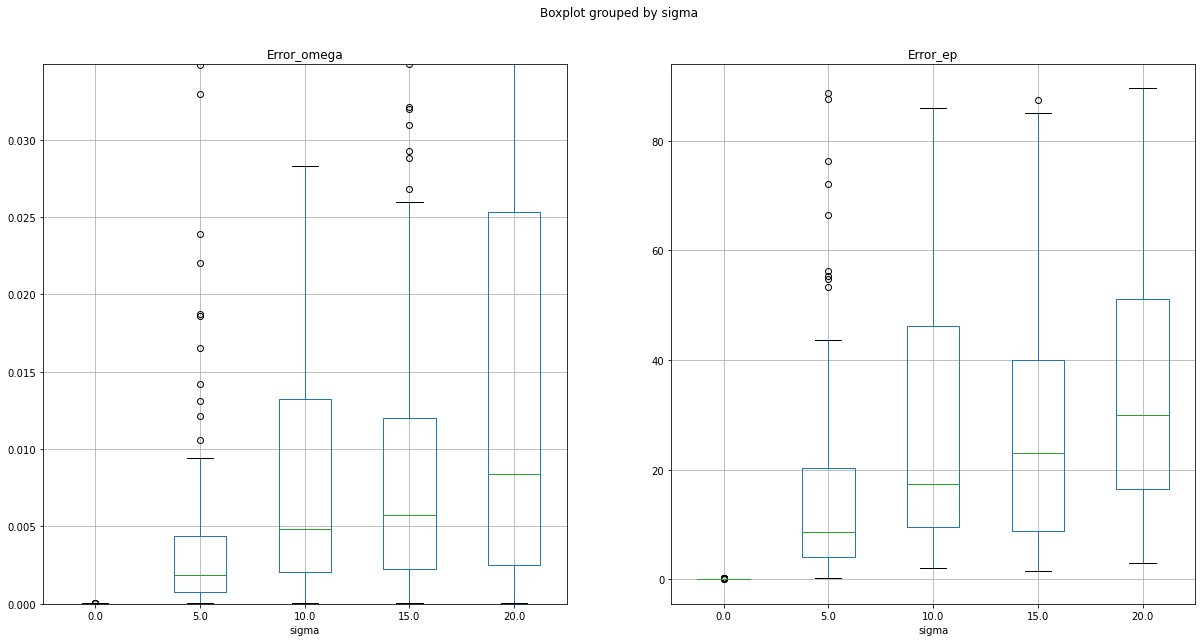

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
df_TM_error.boxplot('Error_omega','sigma', ax=ax[0])
df_TM_error.boxplot('Error_ep','sigma', ax=ax[1])
ax[0].set_ylim(0, max_omega-min_omega)

#plt.savefig("Error_TM_SingleSegment.pdf", format="pdf", bbox_inches="tight")

### 2.3. Running on real data

We can apply the trajectory matching to both real data and running mean. 

In [109]:
TM_example = "RM" 
#TM_example = "Real"

if TM_example == "Real":
    
    df1 = df[df.Age < 60]
    
elif TM_example == "RM":
    
    df_RM['x'] = df_RM.apply(lambda row: spherical2cartesian([np.radians(row["RLat"]), np.radians(row.RLon)])[0], axis=1) 
    df_RM['y'] = df_RM.apply(lambda row: spherical2cartesian([np.radians(row["RLat"]), np.radians(row.RLon)])[1], axis=1) 
    df_RM['z'] = df_RM.apply(lambda row: spherical2cartesian([np.radians(row["RLat"]), np.radians(row.RLon)])[2], axis=1) 
    
    df1 = df_RM[df_RM < 60]

<GeoAxesSubplot:xlabel='RLon', ylabel='RLat'>

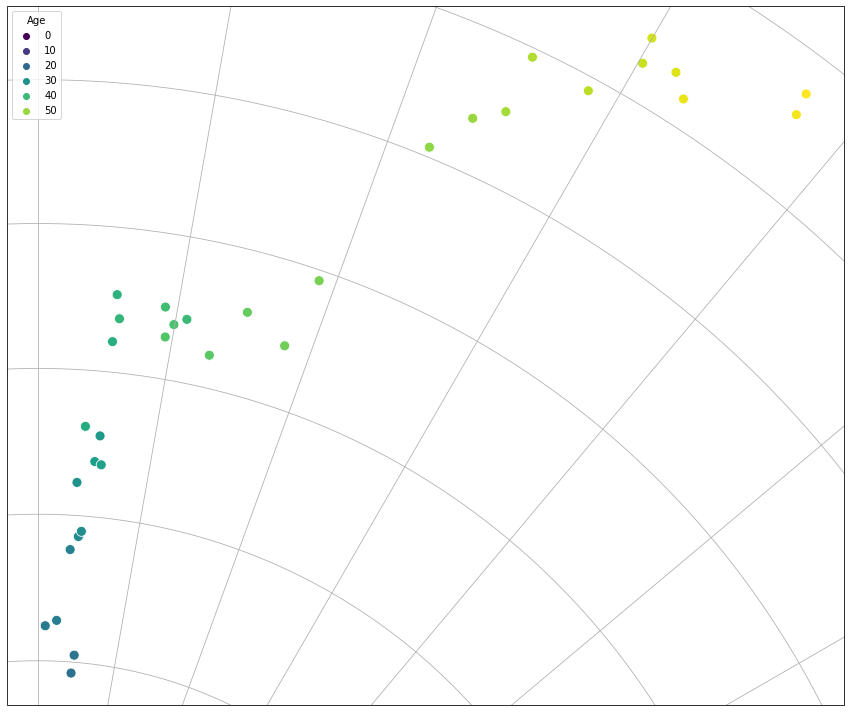

In [110]:
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-90))

ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df1['RLon'], y = df1['RLat'], 
                hue = df1['Age'],  s=100,
                palette="viridis",
                transform = ccrs.PlateCarree())

In [111]:
PPs = [[df1.x[i], df1.y[i], df1.z[i]] for i in df1.index]

optimum = fit_segment(df1.Age.values, PPs)
optimum

 final_simplex: (array([[-0.00146590271765 , -0.004894193892386,  0.022441963482463],
       [-0.00145965208868 , -0.0048946959063  ,  0.022352373995839],
       [-0.001463928112911, -0.004893799607678,  0.022399911385424],
       [-0.001460906060693, -0.004893104962573,  0.022371145290692]]), array([0.019300200014811, 0.019300217597345, 0.019300220082815,
       0.019300244064759]))
           fun: 0.01930020001481112
       message: 'Optimization terminated successfully.'
          nfev: 191
           nit: 109
        status: 0
       success: True
             x: array([-0.00146590271765 , -0.004894193892386,  0.022441963482463])

In [112]:
np.degrees(np.linalg.norm(optimum.x))

1.3187289635672095

In [116]:
np.degrees(cartesian2spherical(-optimum.x/np.linalg.norm(optimum.x)))

array([-77.17494059896488,  73.3260572717873 ])

## Gradient Matching

We first need to find a smoothing of the data points that will allow us to estimate the derivatives. 

### 3.1. Smoothing

We are going to fit cubic splines to the trajectory of the paleomagnetic poles. However, since these are 3-dimensional vectors constrained to lie in the unit sphere, it is not straightforward how to do this. We can use two independent one dimensional splines for latitude and longitude, but the longitude has a erratic behavior close to the poles which leads to unrealistic fits. Instead, we are going to consider three independent fits for each Cartesian coordinate and then normalize the smoothing to have unit norm. 

In [70]:
# We first sort by age and aggregate the paleomagnetic poles with the same age
df2 = df.sort_values("Age").groupby("Age").median().reset_index()
df2

,Age,Q,a95,Plate_code,Lat,Lon,CLat,CLon,RLat,RLon,Eplat,Eplong,Epang,x,y,z
0,0.5,4.0,4.40,301.0,-86.30,267.50,NaN,NaN,-86.3,-63.10,18.3,-47.00,0.10,0.028409,-0.055996,-0.997916
1,0.8,5.0,9.10,101.0,-86.40,8.40,NaN,NaN,-86.4,9.20,79.2,23.00,0.20,0.061983,0.010039,-0.998027
2,1.0,5.0,4.30,101.0,-87.50,265.90,NaN,NaN,-87.5,-75.10,79.9,22.70,0.30,-0.005858,-0.018552,-0.999048
3,1.5,4.0,5.30,101.0,-85.10,272.35,-80.6,38.7,-82.8,39.35,80.8,22.80,0.40,0.041065,0.001613,-0.991678
4,2.0,4.0,6.00,755.5,-87.25,87.20,NaN,NaN,-87.3,82.55,29.2,-21.45,0.05,0.004067,0.031103,-0.998890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,123.5,6.0,2.60,201.0,-89.10,3.30,NaN,NaN,-56.3,76.30,51.0,-34.30,53.60,0.131408,0.539059,-0.831954
113,124.0,5.0,5.90,202.0,-72.00,25.00,NaN,NaN,-39.1,73.60,50.9,-34.20,53.70,0.219110,0.744472,-0.630676
114,124.5,3.0,9.30,709.0,-60.00,82.00,NaN,NaN,-60.9,80.40,50.3,6.40,-1.50,0.081106,0.479525,-0.873772
115,125.0,5.0,7.50,101.0,-71.00,16.90,NaN,NaN,-49.4,83.70,65.4,-18.90,56.80,0.071412,0.646844,-0.759271


In [85]:
# define the splines and their respective smoothing parameters

spl_x = UnivariateSpline(df2['Age'], df2['x'], k=3)
spl_x.set_smoothing_factor(.75)

spl_y = UnivariateSpline(df2['Age'], df2['y'], k=3)
spl_y.set_smoothing_factor(.67)

spl_z = UnivariateSpline(df2['Age'], df2['z'], k=3)
spl_z.set_smoothing_factor(0.1025)

For the choice of the smoothing parameter in the splines smoothing, we use leave-one-out cross validation:

In [95]:
def loocv(df, by='x', min_lamb=0.6, max_lamb=1.0):
    
    all_lamb = np.linspace(min_lamb, max_lamb, 50)
    all_CV = []

    for lamb in all_lamb:

        error = 0

        for age in df.Age:

            df_ = df[df.Age != age]

            spl = UnivariateSpline(df_['Age'], df_[by], k=3)
            spl.set_smoothing_factor(lamb)

            error += (df.loc[df.Age==age, by].values[0] - spl(age)) ** 2

        all_CV.append(error)
        
    fig, axes = plt.subplots(1, 1, figsize=(8,8))
    axes.plot(all_lamb, all_CV, 'o-')
    axes.set_xlabel("Smoothing parameter")
    axes.set_ylabel("Leave-one-out Cross Validation")
    #plt.savefig("loocv_x", format="pdf", bbox_inches="tight")
        
    return all_CV

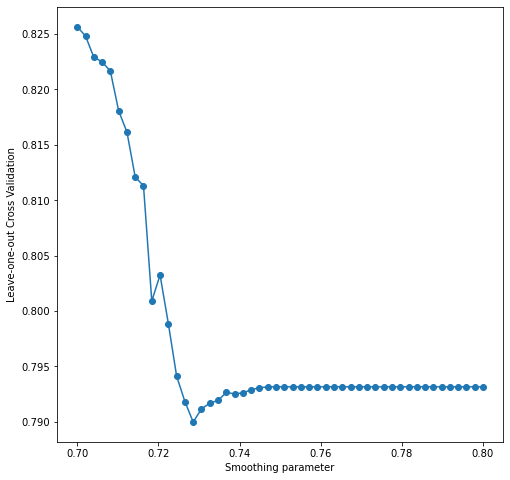

In [96]:
# We pick the smoothing parameter as the minimum of the loocv for each coordinate x, y and z. 
loocv(df2, 'x', 0.70, 0.80);

Now we normalize the smoothing to have unit norm and check that the smoothing still approximate the PPs:

In [97]:
ts = np.linspace(0, max(df2.Age), 1000)

Xs = [spl_x(t) / np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)]) for t in ts]
Ys = [spl_y(t) / np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)]) for t in ts]
Zs = [spl_z(t) / np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)]) for t in ts]

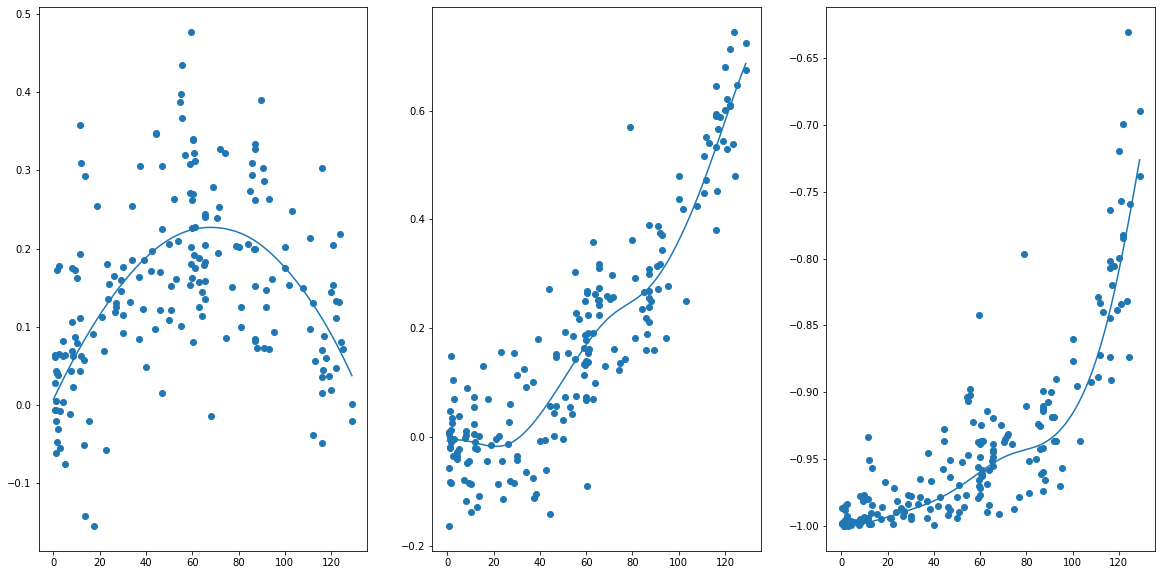

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))


ax[0].scatter(df.Age, df.x)
ax[0].plot(ts, Xs)

ax[1].scatter(df.Age, df.y)
ax[1].plot(ts, Ys)

ax[2].scatter(df.Age, df.z)
ax[2].plot(ts, Zs)

#plt.savefig("Independen_smoothing.pdf", format="pdf", bbox_inches="tight")

<GeoAxesSubplot:xlabel='RLon', ylabel='RLat'>

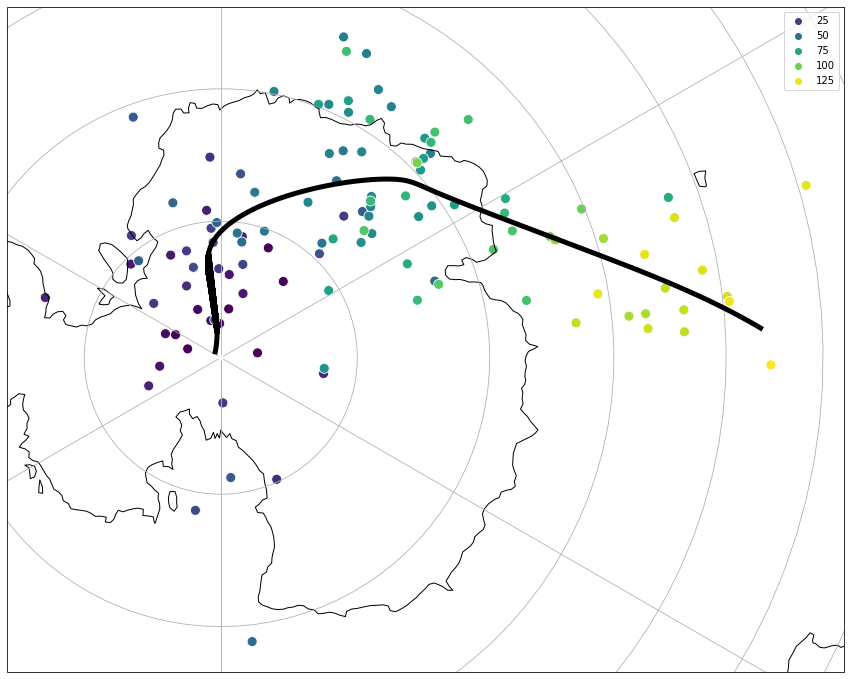

In [99]:
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-90))
ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df2['RLon'], y = df2['RLat'], 
                hue = df2['Age'],  s=100,
                palette="viridis",
                transform = ccrs.PlateCarree())


SLat = np.degrees([cartesian2spherical([Xs[t], Ys[t], Zs[t]])[0] for t in range(len(Xs))])
SLon = np.degrees([cartesian2spherical([Xs[t], Ys[t], Zs[t]])[1] for t in range(len(Xs))])


sns.lineplot(ax=ax, x = SLon, y = SLat, color='black', lw=5, sort=True, 
             transform = ccrs.PlateCarree())

#plt.savefig("smoothing.pdf", format="pdf", bbox_inches="tight")

In [100]:
def smooth_trajectory(t):
    
    x = spl_x(t) / np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)])
    y = spl_y(t) / np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)]) 
    z = spl_z(t) / np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)]) 

    return [x,y,z]

def smooth_derivative(t):
                          
    dx = spl_x.derivative(1)(t)
    dy = spl_y.derivative(1)(t)
    dz = spl_z.derivative(1)(t)
    
    norm = np.linalg.norm([spl_x(t), spl_y(t), spl_z(t)])
    inner = np.dot([spl_x(t), spl_y(t), spl_z(t)], [dx, dy, dz])
    
    return [ dx / norm - inner * spl_x(t) / (norm)**3,
             dy / norm - inner * spl_y(t) / (norm)**3,
             dz / norm - inner * spl_z(t) / (norm)**3 ]

### 3.2. Estimation of the parameters

We first define some utils functions we need in order to numerically integrate and solve the equation for L. 

In [160]:
def integrate(xs, ys):
    
    res = 0
    
    for i in range(len(xs)-1):
        
        res += (xs[i+1]-xs[i]) * (ys[i]+ys[i+1]) / 2
    
    return res



def fit_L (t0, t1):

    times = np.linspace(t0, t1, 1000)

    XxDX = []
    Js = []

    for t in times:

        XxDX.append(np.cross(smooth_trajectory(t), smooth_derivative(t)))

        x, y, z = smooth_trajectory(t)

        J = [[ 1 - x**2 , - x*y    , - x*z      ],
             [ - x*y    , 1 - y**2 , - y*z      ],
             [ - x*z    , - y*z    , 1 - z**2  ]]
        Js.append(np.matrix(J))


    int_XxDX = integrate(times, XxDX)
    int_J = integrate(times, Js)

    L = np.linalg.inv(int_J).dot(int_XxDX)

    Loss = []

    for t in times:

        Loss.append( np.linalg.norm( smooth_derivative(t) - np.cross(L, smooth_trajectory(t)) )**2 )

    opt_loss = integrate(times, Loss)

    return np.array(L).reshape(-1), opt_loss

Now, we can solve the equation for any given interval of time:

In [161]:
L, loss = fit_L(0, 60)

In [162]:
np.degrees(np.linalg.norm(L))

1.9767452494613995

In [164]:
np.degrees(cartesian2spherical(-L / np.linalg.norm(L)))

array([-81.35743805371422,  67.79747073196089])

### 3.3. Change point detection

In [165]:
%%time

all_changepoints = np.linspace(10, 110, 100)
Loss2 = []

for t in all_changepoints:
    
    L1, loss1 = fit_L(0,t)
    L2, loss2 = fit_L(t,120)
    
    Loss2.append(loss1 + loss2)

CPU times: user 2min 37s, sys: 942 ms, total: 2min 38s
Wall time: 2min 37s


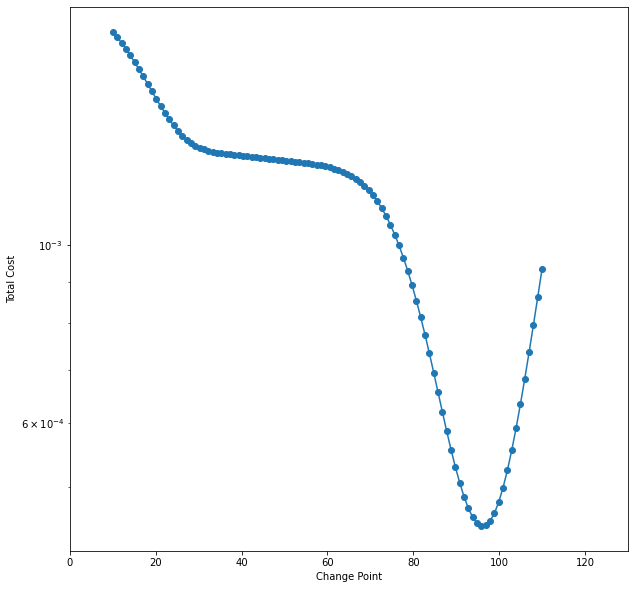

In [173]:
plt.figure(figsize=(10,10))
plt.plot(all_changepoints, Loss2, 'o-')
plt.xlim(0,130)
plt.yscale('log')
plt.xlabel("Change Point")
plt.ylabel("Total Cost")

#plt.savefig("changepoint1.pdf", format="pdf", bbox_inches="tight")

In [211]:
%%time

all_t1 = np.arange(5, 125, 5, dtype=int)
all_t2 = np.arange(5, 125, 5, dtype=int)

Loss = np.empty((len(all_t1),len(all_t2)))
Loss[:] = np.nan

for i, t1 in enumerate(all_t1):
    for j, t2 in enumerate(all_t2):
        
        if t1 + 5 < t2:
            
            Loss[i,j] = fit_L(0, t1)[1] + fit_L(t1, t2)[1] + fit_L(t2, 130)[1]

CPU times: user 9min 58s, sys: 4.34 s, total: 10min 3s
Wall time: 10min 3s


<AxesSubplot:>

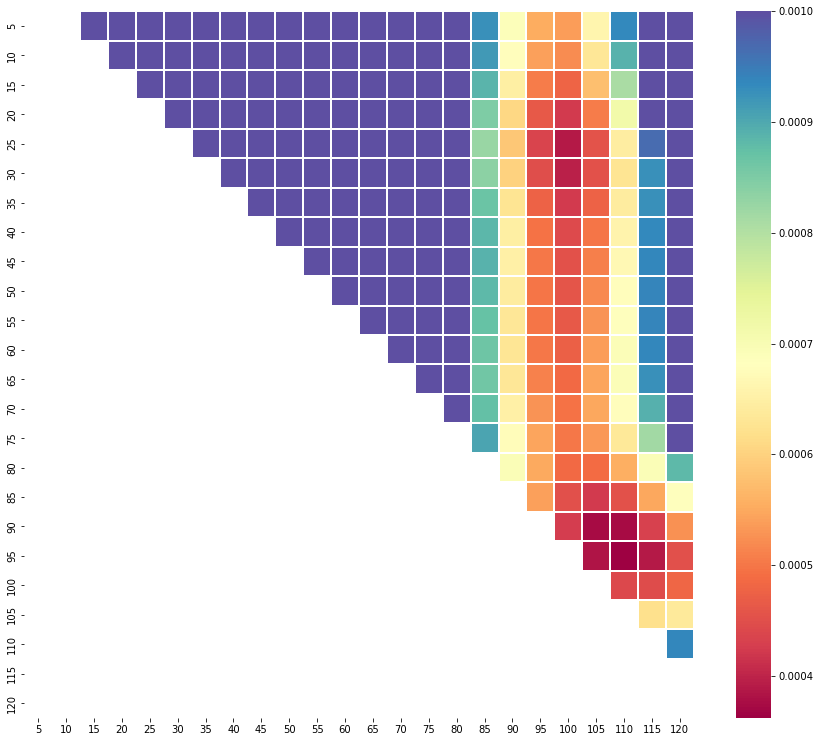

In [234]:
plt.figure(figsize=(15,13))
sns.heatmap(Loss, linewidths=.1, mask=np.isnan(Loss), xticklabels=all_t1, yticklabels=all_t2,vmax=.001, cmap="Spectral")
#plt.savefig("changepoint2.pdf", format="pdf", bbox_inches="tight")